In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve
from google.colab import files
import warnings
warnings.filterwarnings("ignore");

RAND = 10

In [4]:
files.upload()

Saving train.csv to train.csv


{'train.csv': b'client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default\n25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.00875292,1,50,1,2,18000,4,1,N,0\n63161,12MAR2014,SCH,F,59,N,N,0,0,-1.53227621,3,50,2,3,19000,4,1,N,0\n25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.40814226,1,80,1,2,30000,1,4,Y,0\n16222,23JAN2014,SCH,F,53,N,N,0,0,-2.05747134,2,50,2,3,10000,1,3,N,0\n101655,18APR2014,GRD,M,48,N,N,0,1,-1.24472274,1,60,2,3,30000,1,4,Y,0\n41415,18FEB2014,SCH,M,27,Y,N,0,1,-2.03225725,0,50,1,1,15000,2,3,N,0\n28436,04FEB2014,SCH,M,39,N,N,0,0,-2.22500363,0,60,1,2,28000,1,1,N,0\n68769,17MAR2014,SCH,F,39,N,N,0,0,-1.52273914,1,50,2,3,45000,3,3,N,0\n38424,14FEB2014,SCH,F,50,Y,N,1,0,-1.67606085,0,50,1,1,30000,1,4,N,0\n4496,10JAN2014,UGR,F,54,N,N,0,0,-2.69517561,1,50,2,3,24000,1,3,N,0\n26995,03FEB2014,UGR,M,50,Y,N,2,0,-1.70010457,1,80,2,3,60000,1,4,Y,0\n91883,08APR2014,GRD,M,29,N,N,0,0,-1

# Импорт данных

**Описания полей**

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [7]:
df = pd.read_csv('train.csv')

In [ ]:
print(f'Train size = {df.shape}')

In [ ]:
df.info()

In [8]:
df.education.isna().sum() / df.shape[0]*100
#процентное соотношение пропусков

0.41599479667746175

In [9]:
df.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

In [11]:
ed_mode = df.education.mode()[0]
df.education = df.education.fillna(ed_mode)

In [ ]:
# Так как обе переменные являются категориальными для улучшения обучения модели лучше изменить тип данных
df[['home_address', 'work_address']] = df[['home_address', 'work_address']].astype(object)

# Exploratory data analysis

**Гипотезы:**

- Возраст "хороших" заемщиков больше, по сравнению с "плохими" (распределения возраста в зависимости от флага дефолта смещено в большую сторону при default=0)
- Уровень образования зависит от возраста, что влияет и на возврат кредита, также люди с высшим образованием чаще являются "хорошими" заемщиками
- При good_work = 0 увеличивается риск невозврата кредита (флаг дефолта)
- Доход "хороших" заемщиков больше, по сравнению с "плохими" (распределения дохода в зависимости от флага дефолта смещено в большую сторону при default=0)
- score_bki напрямую взаимосвязан с default, чем он меньше, тем выше вероятность клиента выплатить кредит банку

## Target

In [14]:
# нормирование на размер датасета
norm_target = (df
               .default
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())
norm_target

default    percent
0        0  87.300641
1        1  12.699359

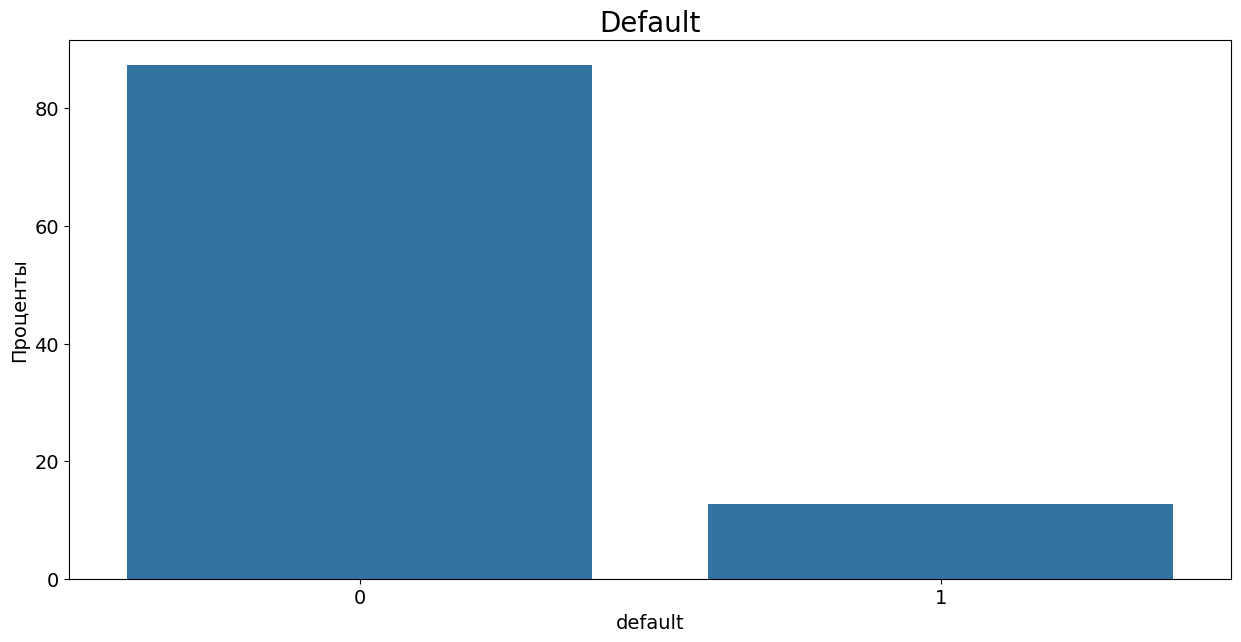

In [27]:


plt.figure(figsize=(15, 7))
ax = sns.barplot(x='default', y='percent', data=norm_target)





plt.title('Default', fontsize=20)

plt.xlabel('default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

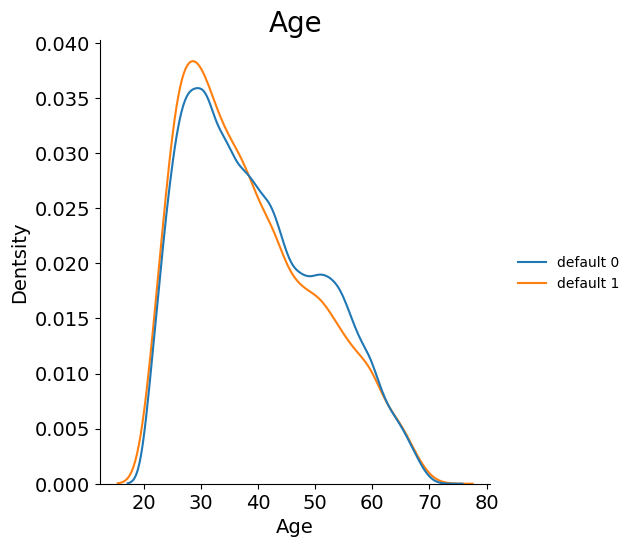

In [20]:
sns.displot(
    {
        "default 0": df[df.default == 0].age,
        "default 1": df[df.default == 1].age
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('Age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [21]:
df.groupby('default')['age'].median()

default
0    38.0
1    36.0
Name: age, dtype: float64

In [22]:
df.groupby('default')['age'].mean()

default
0    39.390504
1    38.525395
Name: age, dtype: float64

In [23]:
df.groupby('default')['age'].apply(lambda x: x.value_counts().index[0]).reset_index()

default  age
0        0   31
1        1   26

Есть небольшие различия по возрасту в разрезе default, гипотеза подтвердилась

## Education

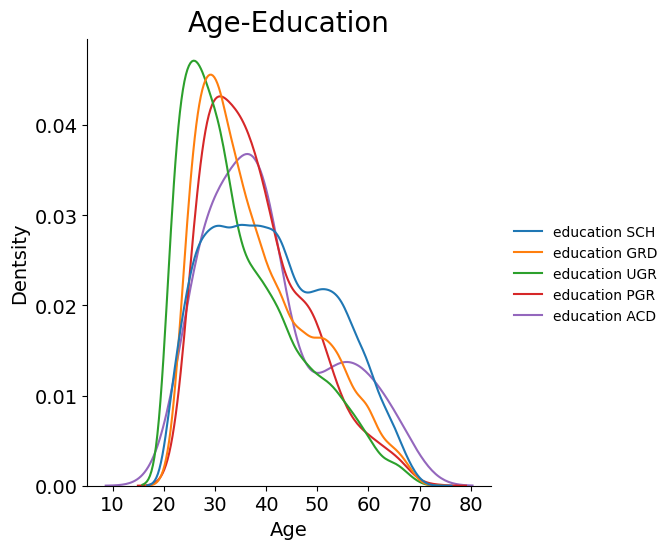

In [24]:
sns.displot(
    {
        "education SCH": df[df.education == 'SCH'].age,
        "education GRD": df[df.education == 'GRD'].age,
        "education UGR": df[df.education == 'UGR'].age,
        "education PGR": df[df.education == 'PGR'].age,
        "education ACD": df[df.education == 'ACD'].age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Age-Education', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Если берем образование SCH , то возраст смещен в большую сторону, по сравнению с тем же UGR. Для ACD характерно смещено распределения возраста влево, если сравниваем с PGR, что и понятно в принципе. Самые молодые - UGR, есть преположение, что в большей степени они будут являться "плохими" заемщиками.

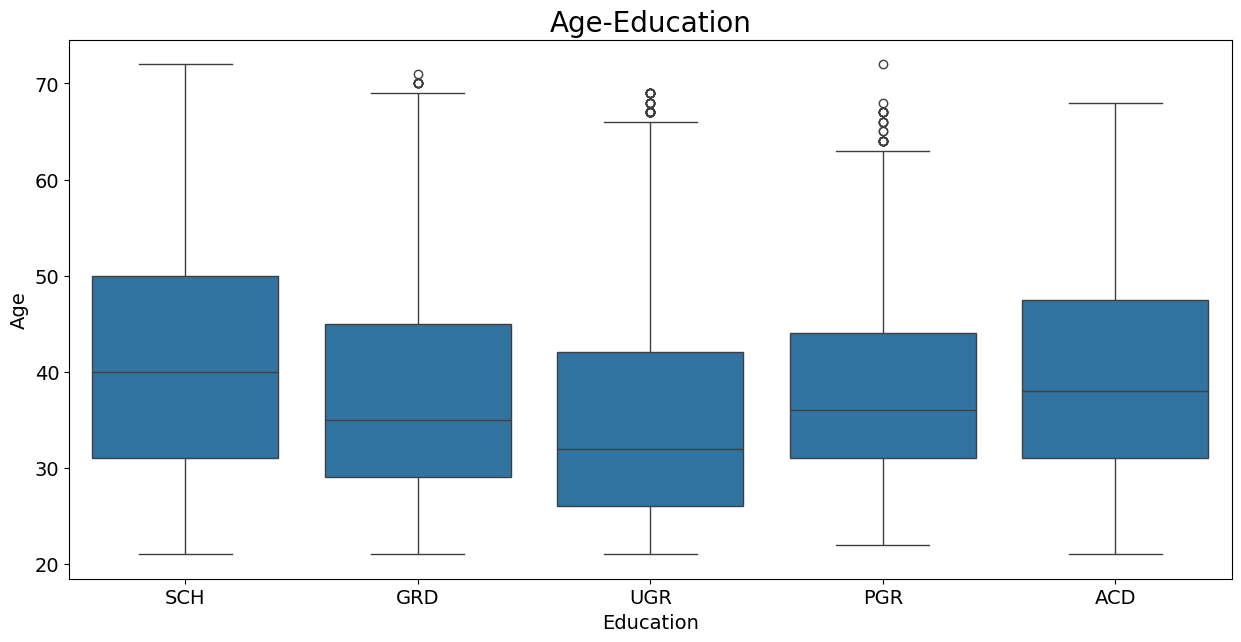

In [28]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', data=df)

plt.title('Age-Education', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

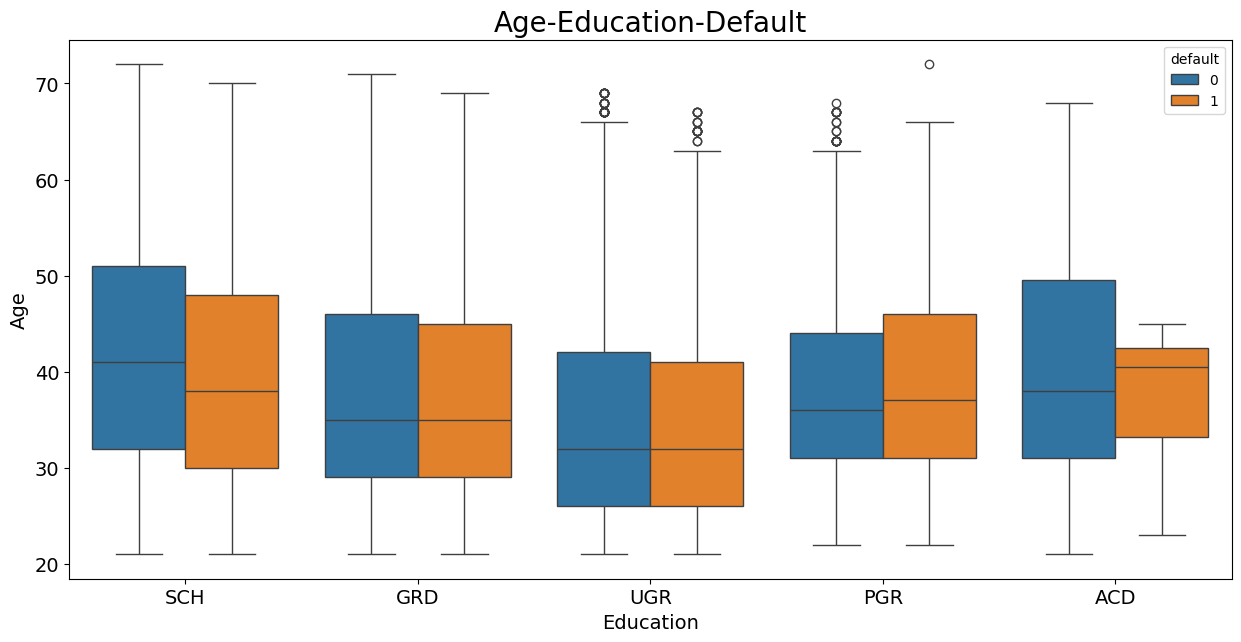

In [29]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', hue='default', data=df)

plt.title('Age-Education-Default', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Интересно то, что если мы берем уровень образования PGR и ACD, то среднее значение возраста у "плохих" заемщиков выше, чем у "хороших", но сам разброс значений и у тех и у тех также высокий. Возможно, если мы берем какой то предел возраст, например, от 30 до 50 лет, то внутри этой группы данный показатель не сильно будет влиять на полную выплату кредита.



In [30]:
df.groupby('education')['age'].median()

education
ACD    38.0
GRD    35.0
PGR    36.0
SCH    40.0
UGR    32.0
Name: age, dtype: float64

## Corr

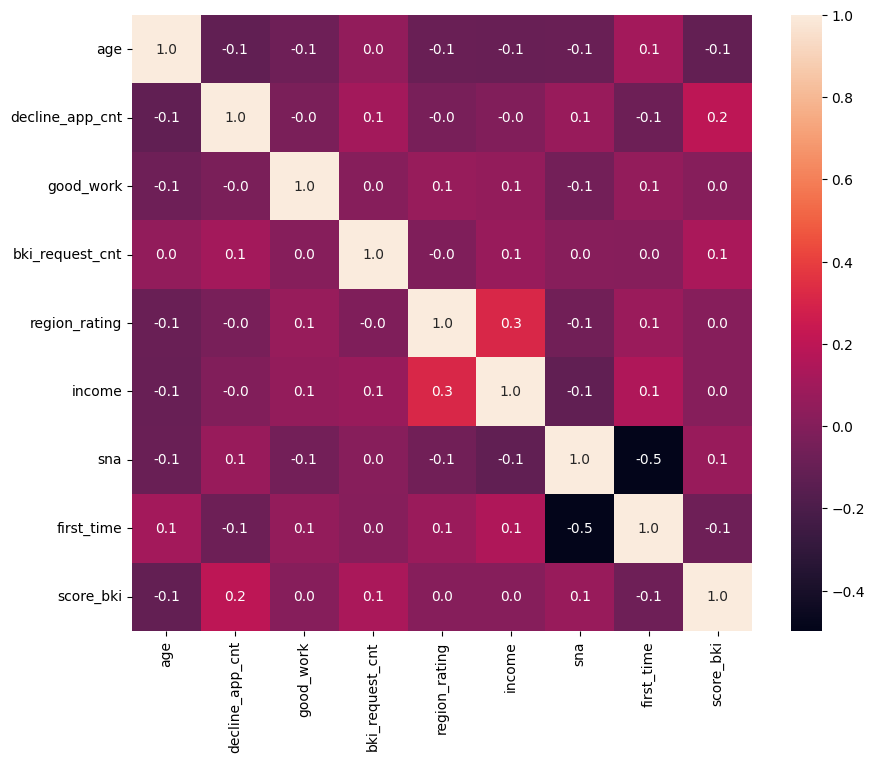

In [31]:
num_cols = ['age', 'decline_app_cnt', 'good_work', 'bki_request_cnt',
       'region_rating', 'income', 'sna', 'first_time', 'score_bki']

plt.figure(figsize=(10, 8))

sns.heatmap(df[num_cols].corr(method='spearman'), annot=True, fmt=".1f");

## Income

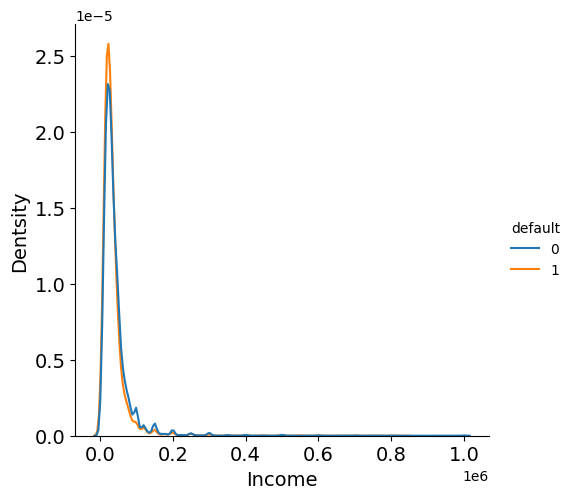

In [32]:
sns.displot(df, x='income', hue='default', kind="kde", common_norm=False)

plt.xlabel('Income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

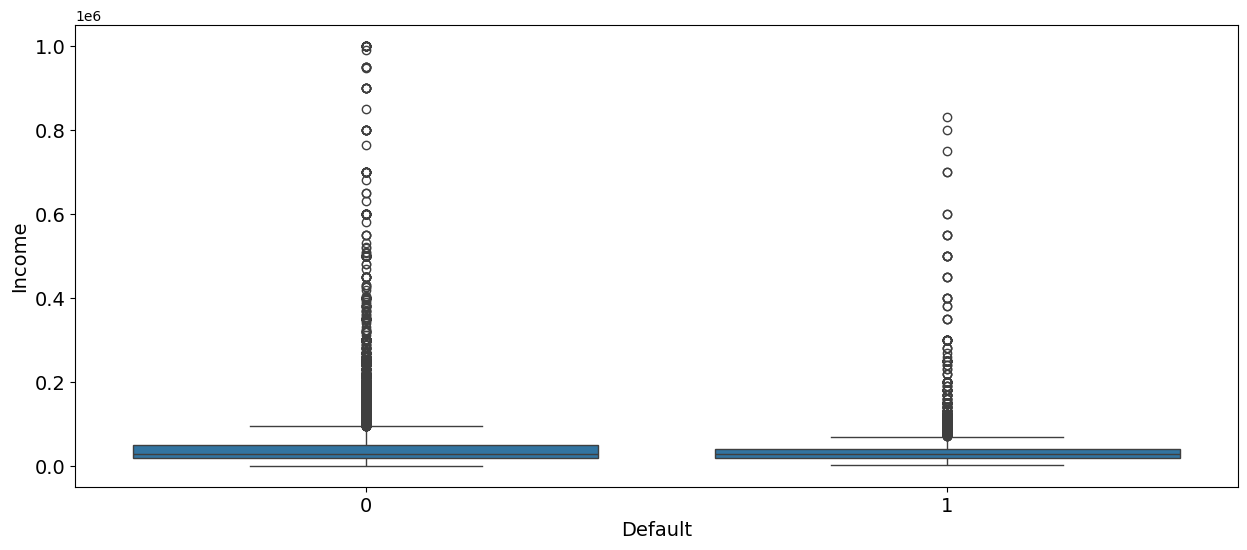

In [33]:
plt.figure(figsize=(15, 6))

sns.boxplot(x='default', y='income', data=df)

plt.ylabel('Income', fontsize=14)
plt.xlabel('Default', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [34]:
df.groupby('default')['income'].mean()

default
0    41799.713288
1    36288.113316
Name: income, dtype: float64

In [35]:
df.groupby('default')['income'].median()

default
0    30000.0
1    28000.0
Name: income, dtype: float64

In [36]:
df_income = df.copy()
df_income.income = np.log(df.income+1)

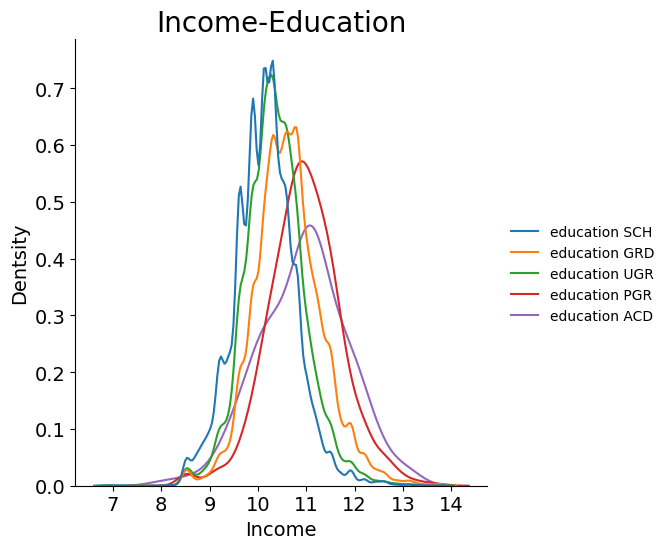

In [37]:
sns.displot(
    {
        "education SCH": df_income[df_income.education == 'SCH'].income,
        "education GRD": df_income[df_income.education == 'GRD'].income,
        "education UGR": df_income[df_income.education == 'UGR'].income,
        "education PGR": df_income[df_income.education == 'PGR'].income,
        "education ACD": df_income[df_income.education == 'ACD'].income,
    },
    kind="kde",
    common_norm=False
)

plt.title('Income-Education', fontsize=20)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

# Feature engineering

In [38]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [39]:
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'income', 'first_time','region_rating']

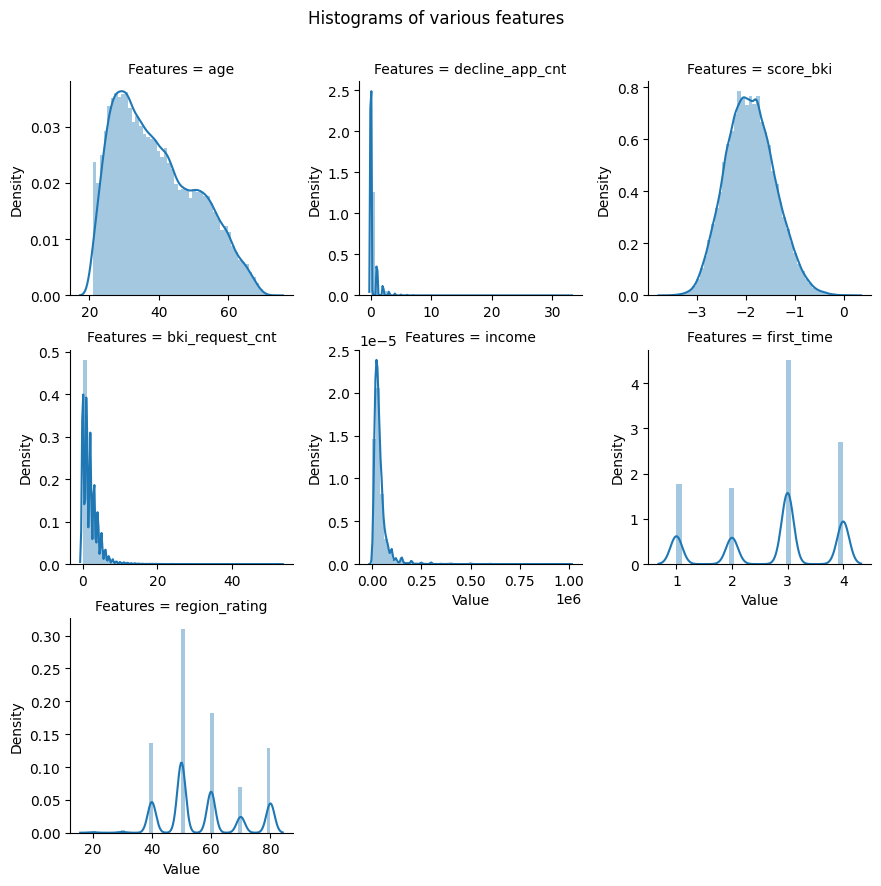

In [40]:
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

In [41]:
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i]+1)

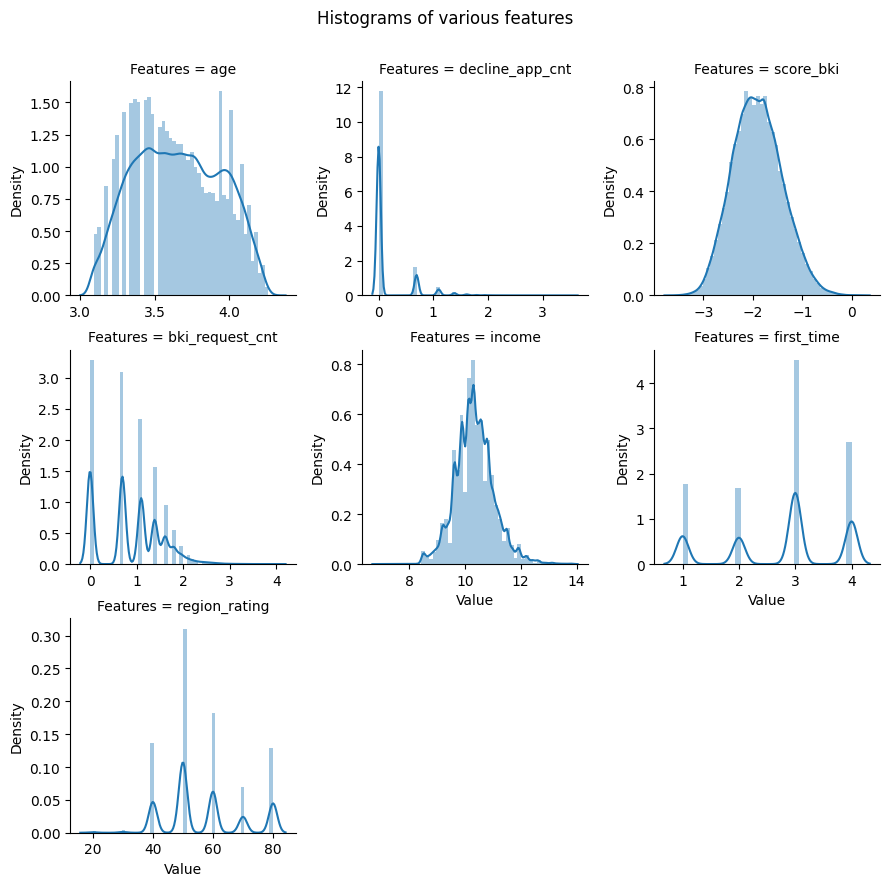

In [42]:
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

In [43]:
# Новый признак - месяц
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
df['month'] = df['app_date'].dt.month.astype(object)

df.drop(['app_date'],  axis=1, inplace=True)

In [44]:
# Средний доход с учетом рейтинга региона

mean_inc_reg = df.groupby('region_rating')['income'].median().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_inc_reg)

In [45]:
# Средний доход с учетом возраста

mean_inc_age = df.groupby('age')['income'].median().to_dict()
df['mean_income_age'] = df['age'].map(mean_inc_age)

In [46]:
# Средний score bki с учетом возраста

mean_bki_age = df.groupby('age')['score_bki'].median().to_dict()
df['mean_bki_age'] = df['age'].map(mean_bki_age)

In [ ]:
df[:5]

In [47]:
cat_cols = ['education', 'sex', 'car', 'car_type', 'good_work', 'home_address', 'work_address',
       'foreign_passport', 'sna', 'month']

In [48]:
num_cols = list(df.dtypes[df.dtypes == float].index) + list(df.dtypes[df.dtypes == int].index)[1:-1]

# Моделирование

In [49]:
df_label = pd.get_dummies(df, columns=cat_cols,
                          drop_first=True).drop('client_id', axis=1)

In [50]:
df_label[:5]

age  decline_app_cnt  score_bki  bki_request_cnt  region_rating  \
0  4.143135         0.000000  -2.008753         0.693147             50   
1  4.094345         0.000000  -1.532276         1.386294             50   
2  3.258097         1.098612  -1.408142         0.693147             80   
3  3.988984         0.000000  -2.057471         1.098612             50   
4  3.891820         0.000000  -1.244723         0.693147             60   

      income  first_time  default  mean_income_region  mean_income_age  ...  \
0   9.798183           1        0           10.126671         9.903538  ...   
1   9.852247           1        0           10.126671         9.998843  ...   
2  10.308986           4        0           10.757924        10.308986  ...   
3   9.210440           3        0           10.126671        10.212803  ...   
4  10.308986           4        0           10.308986        10.308986  ...   

   home_address_3  work_address_2  work_address_3  foreign_passport_Y  sna_2  \
0           False            True           False               False  False   
1           False           False            True               False  False   
2           False            True           False                True  False   
3           False           False            True               False  False   
4           False           False            True                True  False   

   sna_3  sna_4  month_2  month_3  month_4  
0  False   True     True    False    False  
1  False   True    False     True    False  
2  False  False     True    False    False  
3  False  False    False    False    False  
4  False  False    False    False     True  

[5 rows x 30 columns]

In [51]:
X = df_label.drop('default', axis=1)
y = df_label['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RAND)

## Baseline

In [52]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

In [53]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.7292223969235189
precision: 0.23103500075108907
recall: 0.656423388817755
f1: 0.34177777777777774
logloss: 11.573040795508401


Если банку выгоднее пресказать лучше больше "плохих" клиентов, чтобы избежать большие потери, то лучше ориентироваться еще на метрику recall, если будем сравнивать в baseline и другими алгоритмами, иначе precision.

Добавим метрики в таблицу



In [54]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]

In [55]:
metrics

Baseline_LR
roc-auc       0.729222
precision     0.231035
recall        0.656423
f1            0.341778
logloss      11.573041

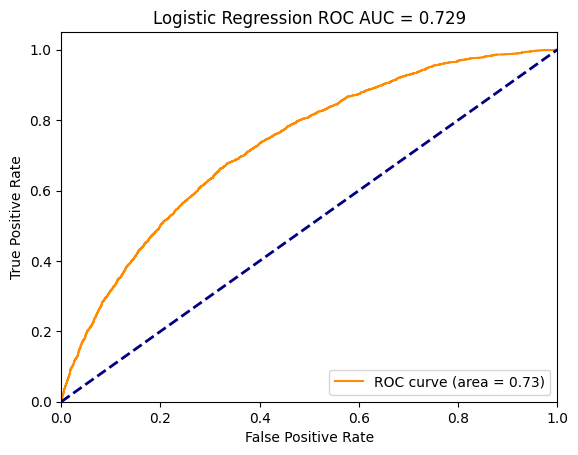

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

# Подбор параметров

In [57]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

In [58]:
#grid_cv.fit(X_train, y_train)

In [59]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [60]:
best_params = {'C': 500.5,
               'l1_ratio': 0.25,
               'max_iter': 400,
               'penalty': 'l2',
               'solver': 'lbfgs'}

In [61]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train, y_train)

y_pred_gr = lr_gr.predict(X_test)
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

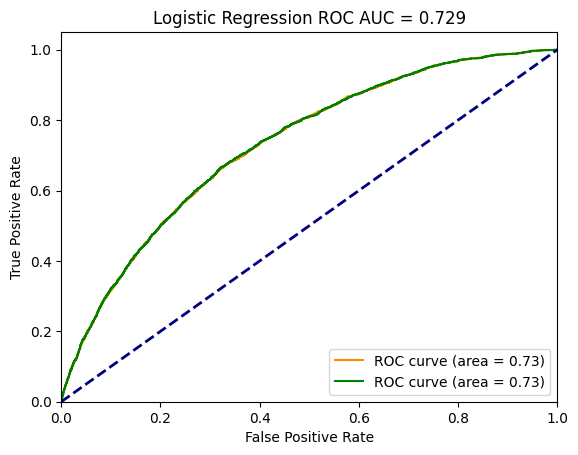

In [62]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_score_gr)

roc_auc_2 = auc(fpr_2, tpr_2)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green', label='ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [63]:
metrics['Grid_LR'] = [roc_auc_score(y_test, y_score_gr),
                      precision_score(y_test, y_pred_gr),
                      recall_score(y_test, y_pred_gr),
                      f1_score(y_test, y_pred_gr),
                      log_loss(y_test, y_pred_gr)]

In [66]:
metrics[:-1]

Baseline_LR   Grid_LR
roc-auc       0.729222  0.729788
precision     0.231035  0.231854
recall        0.656423  0.659838
f1            0.341778  0.343136